**Importing libraries and loading the data**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost
import pickle

In [13]:
#Load pre-counted dataframe
final_df = pd.read_csv('../data/interim/final_df_interim_full_not_agre_sales.csv')
#final_df.date = pd.to_datetime(final_df.date)

In [14]:
final_df.dropna(axis = 0, subset=["sales_d_1", "sales_d_2", "sales_d_3",
               "sales_month_avg", "sales_week_avg"], inplace=True)

In [15]:
#Modeling - data preparation
final_df = final_df.sort_values(by='date')
final_df.d = final_df.d - final_df.d.min() + 1
final_df = final_df[['item_id',  'store_id',  #categorical - product definition, out because of high correlation - 'state_id', 'cat_id', 'id', 'dept_id',
                     'weekday', 'month', 'event_type', #categorical - time definition and event - sesonality
                     'd',  #trend ,out because of high correlation - 'wm_yr_wk', 'year',
                     'sell_price','sales','turnover',
                     "sales_d_1", "sales_d_2", "sales_d_3",
                     "sales_week_avg", "sales_month_avg"]]

In [16]:
#Make dummy variables (one-hot encoding)
#final_df = pd.get_dummies(final_df, columns=['id','item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','weekday', 'month', 'event_type'], drop_first=False)

final_df = pd.get_dummies(final_df, columns=['item_id', 'store_id', 'weekday', 'month', 'event_type'], drop_first=False)

In [17]:
final_df = final_df.drop(columns=['item_id_HOBBIES_1_049', 'store_id_CA_1', 'weekday_Monday', 'month_January'])

In [18]:
#Dataframe to train+validation and test data
X = final_df.drop(columns=['sales'])
y = final_df.sales
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:
turnover_train = X_train.turnover
turnover_test = X_test.turnover

X_train = X_train.drop(columns=['turnover'])
X_test = X_test.drop(columns=['turnover'])

## Modeling

### Baseline model

In [20]:
#Baseline model based on only zeros
y_pred = pd.Series(np.zeros(len(y_test)))
rmse_baseline_sales = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE of baseline model for sales is {rmse_baseline_sales}")

rmse_baseline_turnover = np.sqrt(mean_squared_error(turnover_test, y_pred))
print(f"RMSE of baseline model for turnover is {rmse_baseline_turnover}")

RMSE of baseline model for sales is 1.4402969704813904
RMSE of baseline model for turnover is 7.540213610627589


In [21]:
#Baseline model based on average monthly value
y_pred = X_test.sales_month_avg
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE of better baseline model is {rmse_baseline}")

rmse_baseline_turnover = np.sqrt(mean_squared_error(turnover_test, y_pred*X_test.sell_price))
print(f"RMSE of baseline model for turnover is {rmse_baseline_turnover}")

RMSE of better baseline model is 1.07639247619992
RMSE of baseline model for turnover is 5.342454237117144


### XGBoost model

In [22]:
SEED = 88

param_grid = {
    'objective':['count:poisson','reg:squarederror'],
    'learning_rate': [0.01,0.05,0.1,0.3,0.6,0.8], 
    'n_estimators': [200,250,300,350,400],  
    'subsample': [0.01,0.05,0.1,0.2,0.4,0.6,0.8,1], 
    'max_depth': [2,5,10]
    }

best_RMSE_sales = 999
best_RMSE_turnover = 999

best_params_sales = {}
best_params_turnover = {}

for objective in param_grid['objective']:
    for learning_rate in param_grid['learning_rate']:
        for n_estimators in param_grid['n_estimators']:
            for subsample in param_grid['subsample']:
                for max_depth in param_grid['max_depth']:
                        # Create and train a Random Forest model with the current hyperparameters
                        xgb = xgboost.XGBRegressor(random_state=SEED, 
                                            objective=objective,
                                            learning_rate=learning_rate,
                                            n_estimators=n_estimators,
                                            subsample=subsample,
                                            max_depth=max_depth)
                        
                        xgb.fit(X_train, y_train)

                        # Evaluate the model on the validation set
                        y_pred_xgb = xgb.predict(X_test)
                        RMSE_sales = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

                        # Update the best hyperparameters if this combination is better
                        if RMSE_sales < best_RMSE_sales:
                            best_RMSE_sales = RMSE_sales
                            best_params_sales = {
                                'objective':objective,
                                'learning_rate': learning_rate,
                                'n_estimators': n_estimators,
                                'subsample': subsample,
                                'max_depth': max_depth
                            }

                        RMSE_turnover = np.sqrt(mean_squared_error(turnover_test, y_pred_xgb*X_test.sell_price)) 

                        if RMSE_turnover < best_RMSE_turnover:
                            best_RMSE_turnover = RMSE_turnover
                            best_params_turnover = {
                                'objective':objective,
                                'learning_rate': learning_rate,
                                'n_estimators': n_estimators,
                                'subsample': subsample,
                                'max_depth': max_depth
                            }
                        print(learning_rate,n_estimators,subsample,max_depth, '=> RMSE_sales: ', RMSE_sales, 'RMSE_turnover: ', RMSE_turnover)

0.01 200 0.01 2 => RMSE_sales:  1.152334424572588 RMSE_turnover:  5.735010438196235
0.01 200 0.01 5 => RMSE_sales:  1.150419641579245 RMSE_turnover:  5.746261284406478
0.01 200 0.01 10 => RMSE_sales:  1.1666943898088034 RMSE_turnover:  5.857824341329311
0.01 200 0.05 2 => RMSE_sales:  1.1577438425068383 RMSE_turnover:  5.7695113974676495
0.01 200 0.05 5 => RMSE_sales:  1.1354384230954002 RMSE_turnover:  5.654463057262851
0.01 200 0.05 10 => RMSE_sales:  1.146754821684938 RMSE_turnover:  5.7257717730108855
0.01 200 0.1 2 => RMSE_sales:  1.1587989573130686 RMSE_turnover:  5.77877364727089
0.01 200 0.1 5 => RMSE_sales:  1.1335388061185132 RMSE_turnover:  5.654570834183247
0.01 200 0.1 10 => RMSE_sales:  1.1435303053619579 RMSE_turnover:  5.720025249382068
0.01 200 0.2 2 => RMSE_sales:  1.1603158566260452 RMSE_turnover:  5.7897702523758765
0.01 200 0.2 5 => RMSE_sales:  1.1324124433987666 RMSE_turnover:  5.648321760092635
0.01 200 0.2 10 => RMSE_sales:  1.1359751440431314 RMSE_turnover:  5

In [61]:
print('Best parameters for sale prediction: ',best_params_sales)
print('Best parameters for turnover prediction: ',best_params_turnover)

print('Best RMSE for sales prediction: ',best_RMSE_sales) #15 10 8 6 None, 15 10 4 6 None , 15 10 2 6 None 
print('Best RMSE for turnover prediction: ',best_RMSE_turnover) #15 20 2 2 sqrt, 15 20 4 2 sqrt

Best parameters for sale prediction:  {'objective': 'count:poisson', 'learning_rate': 0.05, 'n_estimators': 400, 'subsample': 0.4, 'max_depth': 5}
Best parameters for turnover prediction:  {'objective': 'count:poisson', 'learning_rate': 0.1, 'n_estimators': 400, 'subsample': 0.8, 'max_depth': 5}
Best RMSE for sales prediction:  1.0477940982840108
Best RMSE for turnover prediction:  5.2132512905735835


In [60]:
SEED=88

objective = best_params_turnover['objective']
learning_rate = best_params_turnover["learning_rate"]
n_estimators = best_params_turnover["n_estimators"]
subsample = best_params_turnover["subsample"]
max_depth = best_params_turnover["max_depth"]


xgb = xgboost.XGBRegressor(random_state=SEED, 
                    objective=objective,
                    learning_rate=learning_rate,
                    n_estimators=n_estimators,
                    subsample=subsample,
                    max_depth=max_depth)

xgb.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_xgb = xgb.predict(X_test)
RMSE = np.sqrt(mean_squared_error(turnover_test, y_pred_xgb*X_test.sell_price))

print(RMSE)

5.2132512905735835


In [47]:
with open('../models/xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)

In [55]:
pd.DataFrame({'Variable':X_train.columns,
              'Importance':xgb.feature_importances_}).sort_values('Importance', ascending=False).head(50)

,Variable,Importance
6,sales_month_avg,0.327433
5,sales_week_avg,0.077115
86,weekday_Saturday,0.023105
87,weekday_Sunday,0.018989
93,month_December,0.017949
2,sales_d_1,0.014642
41,item_id_HOBBIES_1_202,0.012066
103,event_type_National,0.010018
100,month_October,0.009579
32,item_id_FOODS_3_415,0.009121


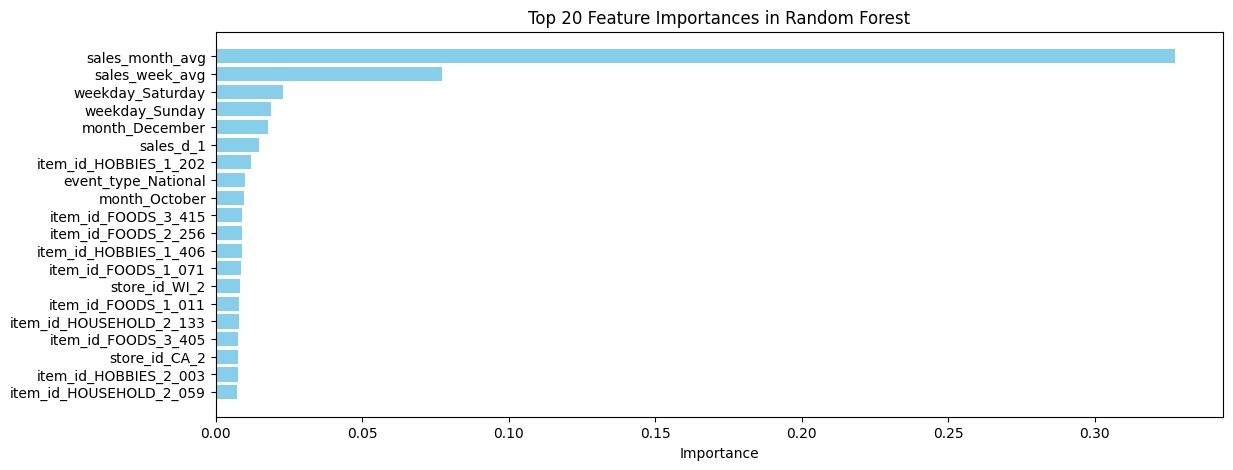

In [63]:
feature_importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importance': xgb.feature_importances_})

top_20_features = feature_importance_df.sort_values('Importance', ascending=True).tail(20)

plt.figure(figsize=(13, 5))
plt.barh(top_20_features['Variable'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances in Random Forest')
plt.show()